In [1]:
# https://colab.research.google.com/github/DhavalTaunk08/NLP_scripts/blob/master/sentiment_analysis_using_roberta.ipynb#scrollTo=HMqQTafXEaei

In [2]:
!nvidia-smi

Mon Oct 24 15:38:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:03:00.0 Off |                  N/A |
| 23%   38C    P8    10W / 250W |    104MiB / 12188MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro P6000        Off  | 00000000:81:00.0 Off |                  Off |
| 26%   

In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from collections import defaultdict
from textwrap import wrap
from datetime import datetime
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [71]:
current_time = datetime.now().strftime("%Y_%m_%d-%I_%M%p")
current_time

'2022_10_24-04_20PM'

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
df1 =pd.read_csv('/users/kent/jmaharja/drugAbuse/input/Tweets_Spring_Summer_2021_coded.csv',
                lineterminator='\n',
                skipinitialspace=True,
                )
# df1['label']= 1
# df1.drop(df1.columns[[0, 2,3,4]], axis=1, inplace=True)
df1.shape

(4467, 5)

In [6]:
df_pos = df1.loc[(df1['Substance'] != 'X') & (df1['Use'] != 'X') & (df1['Intent'] != 'X')]
df_neg = df1.loc[(df1['Substance'] == 'X') & (df1['Use'] == 'X') & (df1['Intent'] == 'X')]

df_pos.drop(df_pos.columns[[0, 2,3,4]], axis=1, inplace=True)
df_neg.drop(df_neg.columns[[0, 2,3,4]], axis=1, inplace=True)
df_pos['label']= 1
df_neg['label']= 0
df_neg.shape,  df_pos.shape

/users/kent/jmaharja/.local/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/users/kent/jmaharja/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

((3605, 2), (456, 2))

In [7]:
# foldername = '400Vs2000'
df1 = df_pos[:400]
df2 = df_neg[:2400]
df = pd.concat([df1,df2])
df.shape

(2800, 2)

In [8]:
# df2 =pd.read_csv('/users/kent/jmaharja/drugAbuse/input/2020_01_31_CleanedTweets.csv',
#                 lineterminator='\n',
#                 skipinitialspace=True
#                 )
# df2.drop(df2.columns[[0, 1]], axis=1, inplace=True)
# df2.rename({'text': 'Tweet'}, axis=1, inplace=True)
# df2['label'] = 0
# df4 = df2[1160000:]
# df2 = df2[:800]
# df4 = df4[:200]
# df2.shape, df4.shape

In [61]:
# df_test =pd.read_csv('/users/kent/jmaharja/drugAbuse/finetune/test_new.csv',
# #                    error_bad_lines=False,
#                 lineterminator='\n',
#                 skipinitialspace=True
#                 )
# df_test.drop(df_test.columns[[1, 2, 3]], axis=1, inplace=True)
# # df_test.rename({'text': 'Tweet'}, axis=1, inplace=True)
# # df_test['label']=/ 1
# df_test = df_test.rename(columns={df_test.columns[1]: 'label'})
df_test_neg = df_neg[2400:3200]
df_test_pos = df_pos[400:]
df3 = pd.concat([df_test_pos,df_test_neg])
df3.shape

(856, 2)

# DATA PREPROCESSING

In [10]:
# #choosing sequence length
# token_lens = []
# for txt in df.Tweet:
#   tokens = tokenizer.encode(txt)
#   token_lens.append(len(tokens))
# sns.distplot(token_lens)
# plt.xlim([0, 200])
# plt.xlabel('Token count')

# MAX_LEN = 80

In [11]:
MAX_LEN = 128
from transformers import RobertaTokenizerFast
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

# Create the tokenizer from a trained one
tokenizer_folder = '/users/kent/jmaharja/drugAbuse/output/oct2022/TokRoBERTa'
tokenizer = RobertaTokenizerFast.from_pretrained(tokenizer_folder, max_len=MAX_LEN)

In [12]:
from torch.utils.data import Dataset
class Tweet_DataSet(Dataset):
   def __init__(self, data, tokenizer, max_len):
    self.data = data
    self.tokenizer = tokenizer
    self.max_len = max_len
  
   def __len__(self):
    return len(self.data)
  
   def __getitem__(self, index:int):
    data_row = self.data.iloc[index]
    tweet = data_row.Tweet
    labels = data_row['label']
    encoding = tokenizer.encode_plus(tweet,
                                     None,
                                     max_length = MAX_LEN,
                                     truncation=True,
                                     pad_to_max_length=True,
                                     add_special_tokens=True,
                                     padding='max_length',
                                     return_token_type_ids=True)

    return {
      'tweet_text': tweet,
      'input_ids': torch.tensor(encoding.input_ids, dtype=torch.long),
      'attention_mask':  torch.tensor(encoding.attention_mask, dtype=torch.long),
      'token_type_ids': torch.tensor(encoding.token_type_ids, dtype=torch.long),
      'targets': torch.tensor(labels, dtype=torch.long)
    }

In [62]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
# df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_val = df_test
df_test = df3
df_train.shape, df_val.shape, df_test.shape

((2520, 2), (280, 2), (856, 2))

In [63]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = Tweet_DataSet(df,tokenizer=tokenizer,max_len=max_len)
  return DataLoader(ds, batch_size=batch_size,num_workers=4)

BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [15]:
# from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel
# from transformers import RobertaModel, RobertaConfig, logging

class TweetModel(RobertaPreTrainedModel):
    def __init__(self, conf, n_classes):
        super(TweetModel, self).__init__(conf)
        self.roberta = transformers.RobertaModel.from_pretrained('/users/kent/jmaharja/drugAbuse/output/sept2022/RoBERTaMLM/', config=conf)
        self.drop_out = nn.Dropout(0.3)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.classifier = nn.Linear(768, n_classes)
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.roberta(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.drop_out(pooler)
        output = self.classifier(pooler)
        return output


In [16]:
from transformers import RobertaConfig

config = RobertaConfig(
    vocab_size=8192,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
    hidden_size=768,
    pad_token_id=1
)

model = TweetModel(config, 2)
model = model.to(device)

Some weights of the model checkpoint at /users/kent/jmaharja/drugAbuse/output/sept2022/RoBERTaMLM/ were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /users/kent/jmaharja/drugAbuse/output/sept2022/RoBERTaMLM/ and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stre

In [17]:
#training
EPOCHS = 16

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss().to(device)

/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [18]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
     
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    targets = d["targets"].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

    big_val, big_idx = torch.max(outputs, dim=1)
    correct_predictions += torch.sum(big_idx == targets)

    loss = loss_fn(outputs, targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double()/n_examples, np.mean(losses)

In [19]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
      )
      _, preds = torch.max(outputs, dim=1)
      correct_predictions += torch.sum(preds == targets)

      loss = loss_fn(outputs, targets)
      losses.append(loss.item())

  return correct_predictions.double()/n_examples, np.mean(losses)

In [20]:
from os.path import exists
# %%time

# set to True if you want to train the model
# otherwise use the existing trained model
FORCE_TRAIN = True

# download trained model
# !gdown --id 1QQ2d0_yFStL2rXz2eHoXpgRMvPWtMMeX

print(40*"*", 'Training')
current_time = datetime.now().strftime("%Y_%m_%d-%I_%M%p")
print(current_time)
history = defaultdict(list)
best_accuracy = 0
val_acc = 0 

for epoch in range(EPOCHS):


#   modelPath = "checkpoint/best_ftc_model_state.bin"
#   if (exists(modelPath) and FORCE_TRAIN == False ): # if model exists load it otherwise rebuild
#     torch.load(modelPath)
#     break # exit out of training
  

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model, val_data_loader,loss_fn, device, len(df_val))

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    curr_time = datetime.now().strftime("%Y_%m_%d-%I_%M%p")
    torch.save(model.state_dict(), 'checkpoint/best_ftc_model_state'+ curr_time +'.bin')
    best_accuracy = val_acc

**************************************** Training
2022_10_24-03_38PM
Epoch 1/16
----------
Train loss 0.3787060732705684 accuracy 0.8579365079365079
Val   loss 0.23409745345513025 accuracy 0.9249999999999999

Epoch 2/16
----------
Train loss 0.19110650128885348 accuracy 0.9357142857142857
Val   loss 0.2493237239153435 accuracy 0.9321428571428572

Epoch 3/16
----------
Train loss 0.10214301648688255 accuracy 0.9726190476190476
Val   loss 0.31263134283168864 accuracy 0.9392857142857143

Epoch 4/16
----------
Train loss 0.0616442043219304 accuracy 0.9861111111111112
Val   loss 0.31353100571626175 accuracy 0.9428571428571428

Epoch 5/16
----------
Train loss 0.03871564611518473 accuracy 0.9928571428571429
Val   loss 0.31961377993381274 accuracy 0.9428571428571428

Epoch 6/16
----------
Train loss 0.0279364953645729 accuracy 0.9948412698412699
Val   loss 0.358161915138933 accuracy 0.9392857142857143

Epoch 7/16
----------
Train loss 0.021067150409629604 accuracy 0.9952380952380953
Val   los

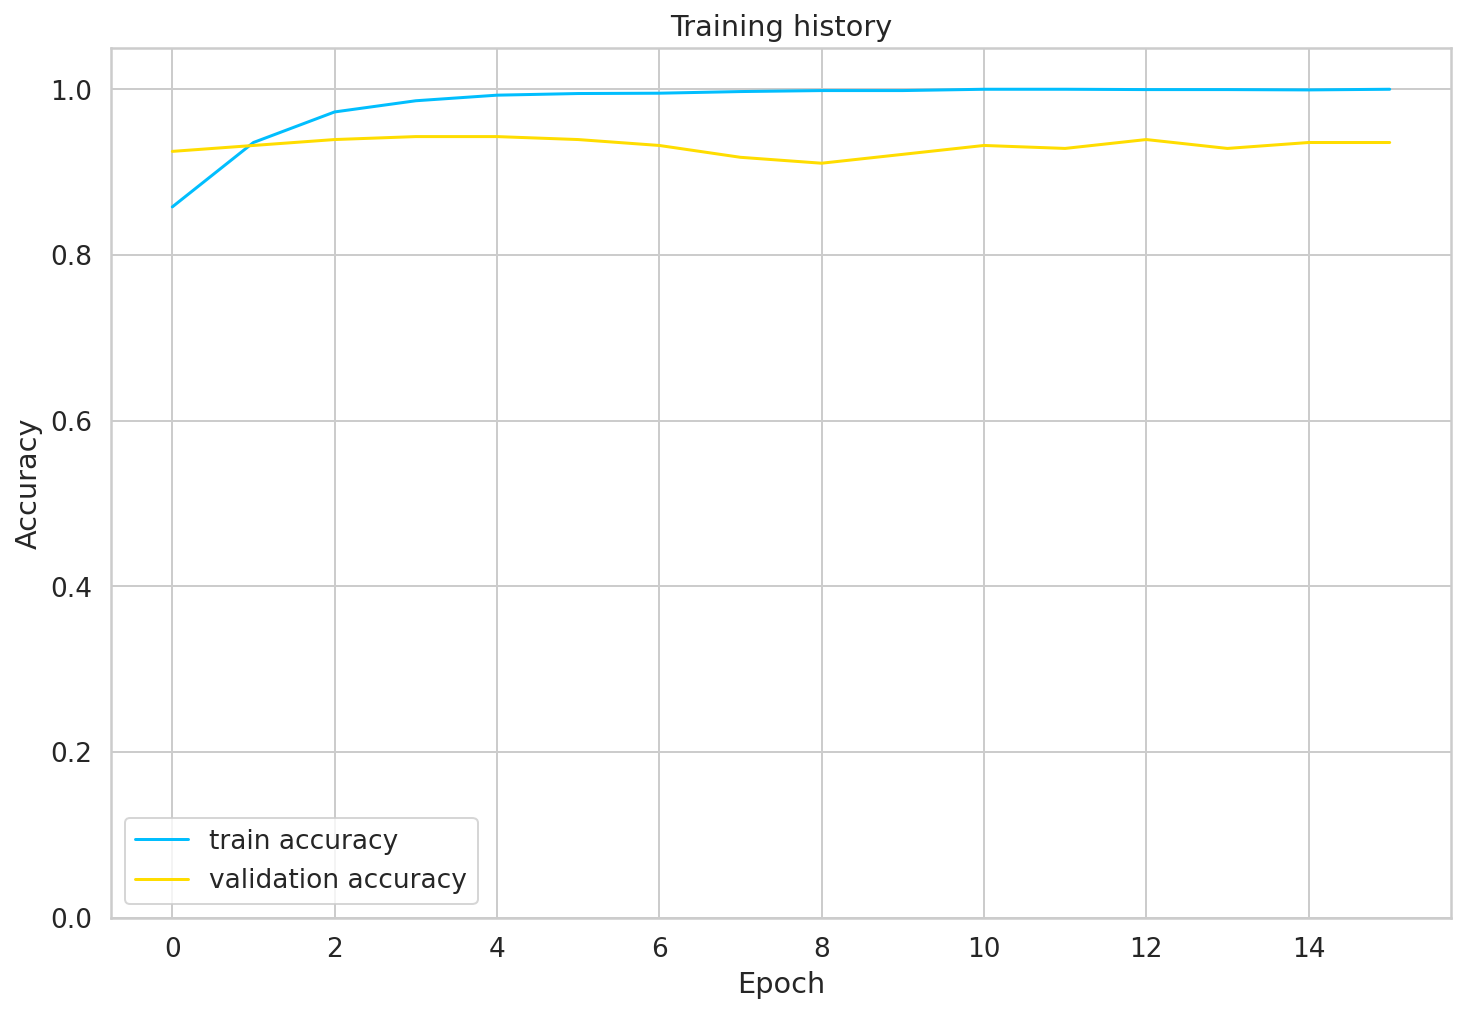

In [21]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1.05]);
plt.savefig('images/training_history '+current_time+'.png')

In [22]:
torch.save(model.state_dict(), 'checkpoint/best_ftc_model_state'+ curr_time +'.bin')

In [23]:
# t_acc = [x.cpu().data.numpy() for x in history['train_acc']]
# v_acc = [y.cpu().data.numpy() for y in history['val_acc']]
# t_acc

In [64]:
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))
test_acc.item()

0.9532710280373831

In [25]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
      _, preds = torch.max(outputs, dim=1)
      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [65]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

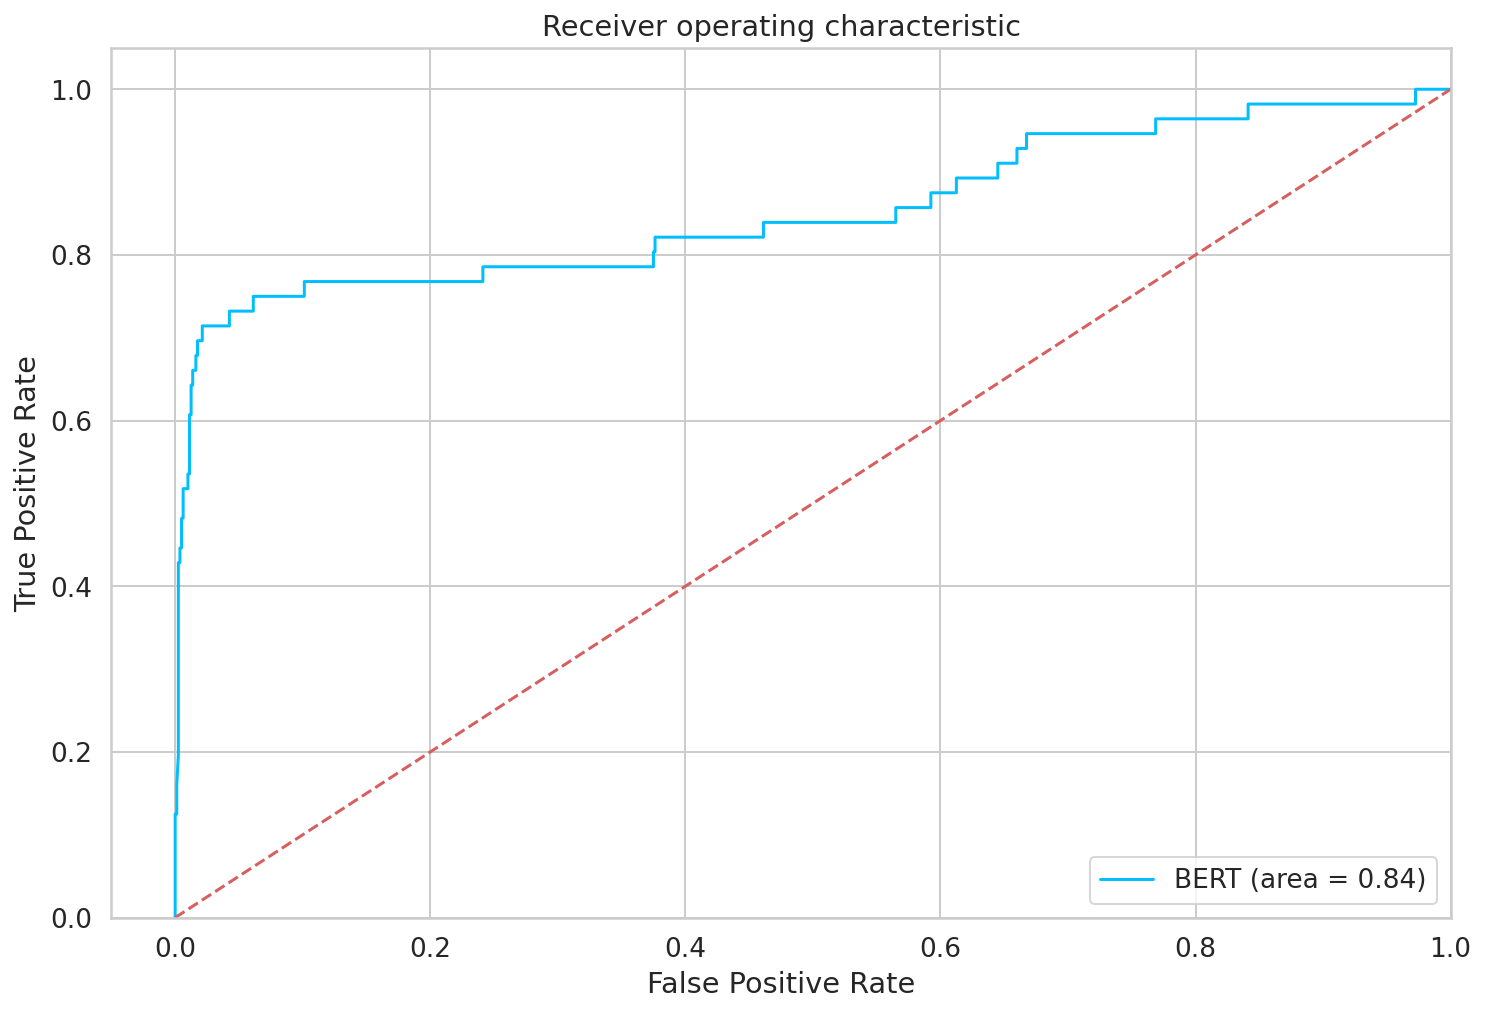

In [72]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test.numpy(), y_pred_probs[:, 1].numpy())
plt.figure()
plt.plot(fpr, tpr, label='BERT (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images/Log_ROC_'+ current_time +'.png')
plt.show()

In [69]:
y_pred_probs_pd = [y.numpy() for y in y_pred_probs]
someListOfLists = list(zip(y_review_texts, y_test.numpy(), y_pred.numpy(), y_pred_probs[:, 1:].numpy().squeeze(), y_pred_probs_pd ))
npa = np.asarray(someListOfLists)
dff = pd.DataFrame(someListOfLists, columns = ['readme', 'Real', 'Predicted', 'Pred-prob', 'All Pred-probs' ])
dff

/users/kent/jmaharja/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,readme,Real,Predicted,Pred-prob,All Pred-probs
0,How much coke have they done? https://t.co/UUR...,1,1,0.999939,"[6.106858e-05, 0.99993896]"
1,@artiequitter talk to ur doctor about these me...,1,1,0.999921,"[7.867903e-05, 0.9999213]"
2,I once snorted Coke off of the butt crack of C...,1,0,0.018665,"[0.9813347, 0.018665353]"
3,"Working with an old woman who is a ""recovering...",1,1,0.999873,"[0.00012733242, 0.9998727]"
4,teyana if you smoke crack i smoke it with you ...,1,1,0.999948,"[5.2391075e-05, 0.99994755]"
...,...,...,...,...,...
851,keep a small circle i cant fuck w squares,0,0,0.000037,"[0.9999628, 3.7152746e-05]"
852,true orange juice has,0,0,0.000071,"[0.99992895, 7.1063034e-05]"
853,Not sore what Norwodd is thinking today but Sp...,0,0,0.000044,"[0.99995565, 4.4371318e-05]"
854,So hype brother flomaster73 is gonna be rockin...,0,0,0.000032,"[0.9999677, 3.232394e-05]"


In [73]:
dff.to_csv('test_result/'+ current_time + 'testtresult.csv')
current_time

'2022_10_24-04_20PM'

In [74]:
print(classification_report(y_test, y_pred, target_names=['Y', 'N']))

              precision    recall  f1-score   support

           Y       0.98      0.97      0.97       800
           N       0.62      0.71      0.67        56

    accuracy                           0.95       856
   macro avg       0.80      0.84      0.82       856
weighted avg       0.96      0.95      0.95       856



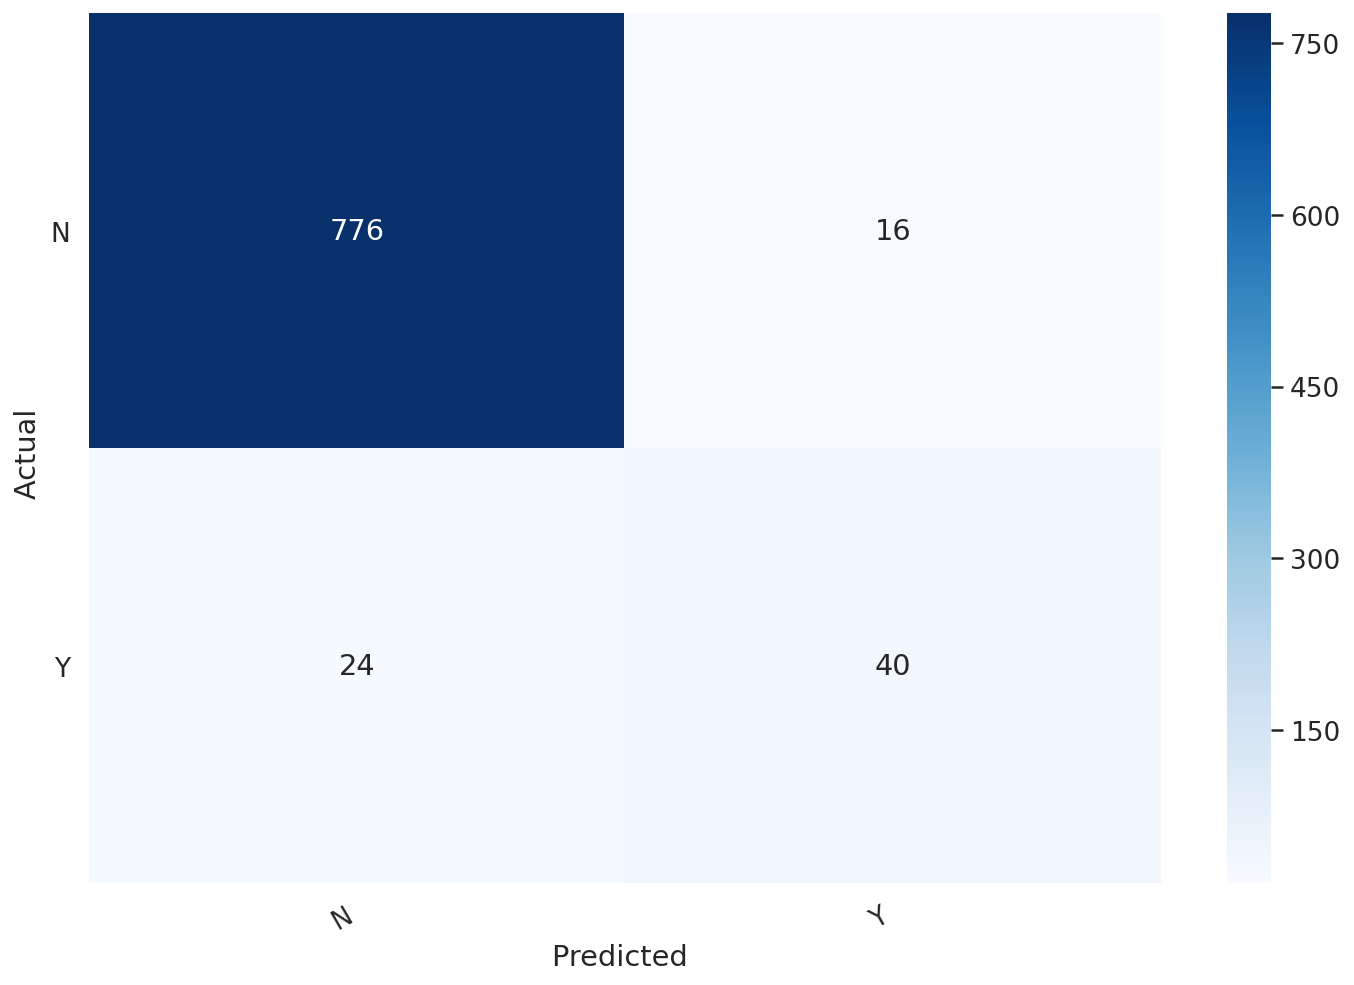

In [75]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('Actual ')
  plt.xlabel('Predicted ')
  plt.savefig('confusion_matrix/'+ 'cm_'+current_time + '.png')

cm = confusion_matrix(y_pred, y_test)
df_cm = pd.DataFrame(cm, index=['N', 'Y'], columns=['N', 'Y'])
show_confusion_matrix(df_cm)

In [32]:
# tweet = "don't eat that food"
# encoded_tweet = tokenizer.encode_plus(
#   tweet,
#   max_length=MAX_LEN,
#   add_special_tokens=True,
#   return_token_type_ids=True,
# #   pad_to_max_length=True,
#   return_attention_mask=True,
#   return_tensors='pt',
# )
# input_ids = encoded_tweet['input_ids'].to(device)
# attention_mask = encoded_tweet['attention_mask'].to(device)
# token_type_ids = encoded_tweet['token_type_ids'].to(device)


# output = model(input_ids, attention_mask, token_type_ids)
# _, prediction = torch.max(output, dim=1)
# print(f'Tweet text: {tweet}')
# print(f'Substance type  : {prediction}')